# 추가 업데이트는 2019-ml-month-2nd-baseline_re 파일에 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [355]:
train_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'train.csv')
sub_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'test.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜(집을 판매한 날짜)
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수(.5는 화장실은 있으나 샤워실은 없는 방)
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도(0~4)
11. condition : 집의 전반적인 상태(1~5)
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
* 1부터13의 지수, 여기서 1,2,3은 건물 구조 및 설계에 미달하고, 7은 평균 수준의 구조 및 설계이며, 11,12,13은 고품질 수준의 구조 및 설계를 나타냅니다.
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [356]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [357]:
y = data['price']

del data['price']

In [358]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [359]:
data.shape

(21503, 20)

In [360]:
y.shape

(15035,)

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

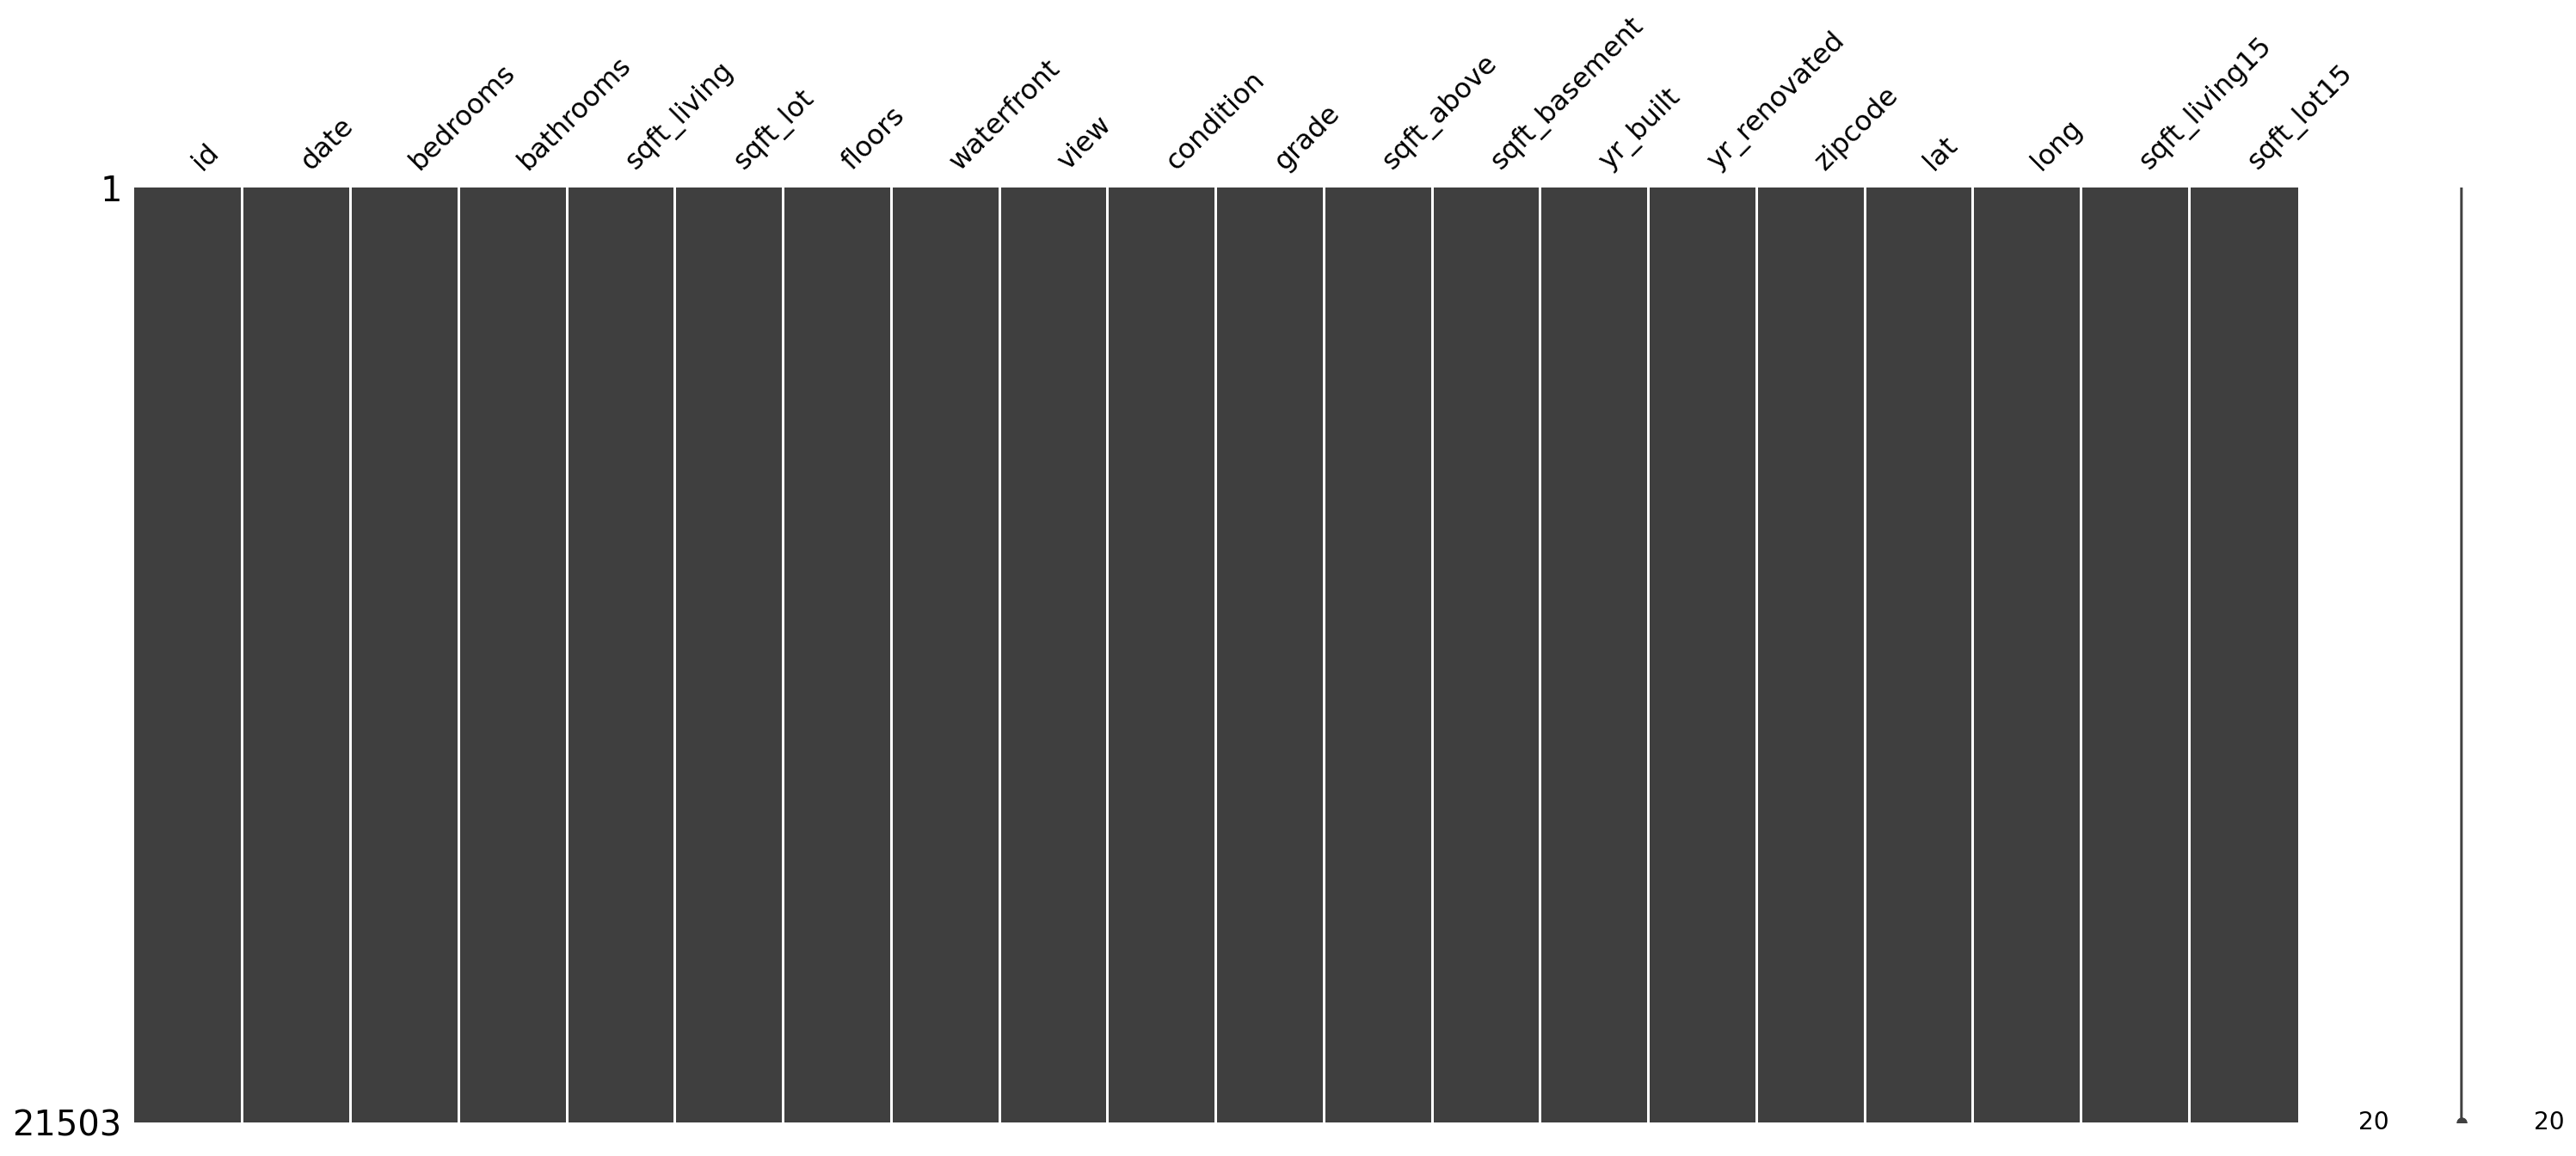

In [361]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [362]:
data.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [363]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

In [364]:
data['date']

0       201410
1       201502
2       201502
3       201406
4       201501
         ...  
6463    201406
6464    201501
6465    201502
6466    201406
6467    201501
Name: date, Length: 21503, dtype: object

In [365]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  object 
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

In [366]:
data['date'] = data['date'].astype('int64')

In [367]:
data.reset_index(drop=True,inplace=True)

In [368]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m')

In [369]:
data['date']

0       2014-10-01
1       2015-02-01
2       2015-02-01
3       2014-06-01
4       2015-01-01
           ...    
21498   2014-06-01
21499   2015-01-01
21500   2015-02-01
21501   2014-06-01
21502   2015-01-01
Name: date, Length: 21503, dtype: datetime64[ns]

<AxesSubplot:xlabel='date', ylabel='price'>

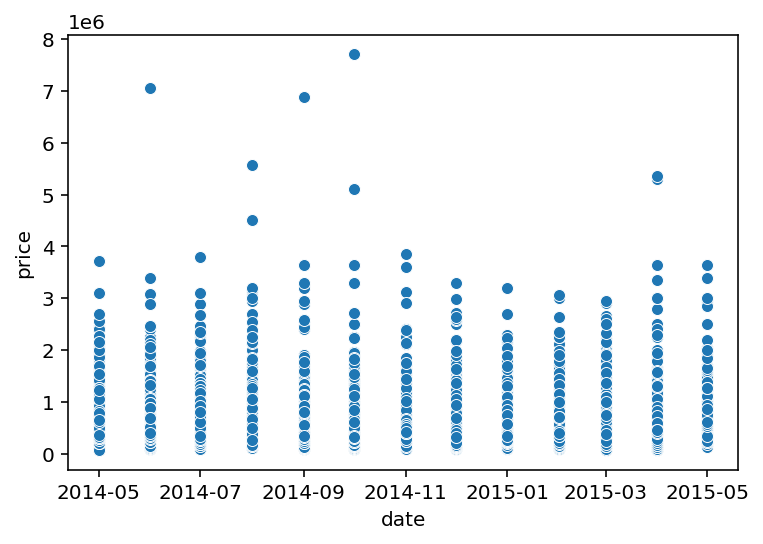

In [370]:
sns.scatterplot(data['date'],y)

In [371]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data = data.drop(columns=['date'])

In [372]:
data.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       1.00         1180      5650     1.0           0     0   
1         2       1.00          770     10000     1.0           0     0   
2         3       2.00         1680      8080     1.0           0     0   
3         3       2.25         1715      6819     2.0           0     0   
4         3       1.50         1060      9711     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        1180              0      1955             0   
1          3      6         770              0      1933             0   
2          3      8        1680              0      1987             0   
3          3      7        1715              0      1995             0   
4          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98178  47.5112 -122.257           1340        5650  2014     10  
1    98028  47.7379 -122.233           2720        8062  2015      2  
2    98074  47.6168 -122.045           1800        7503  2015      2  
3    98003  47.3097 -122.327           2238        6819  2014      6  
4    98198  47.4095 -122.315           1650        9711  2015      1

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

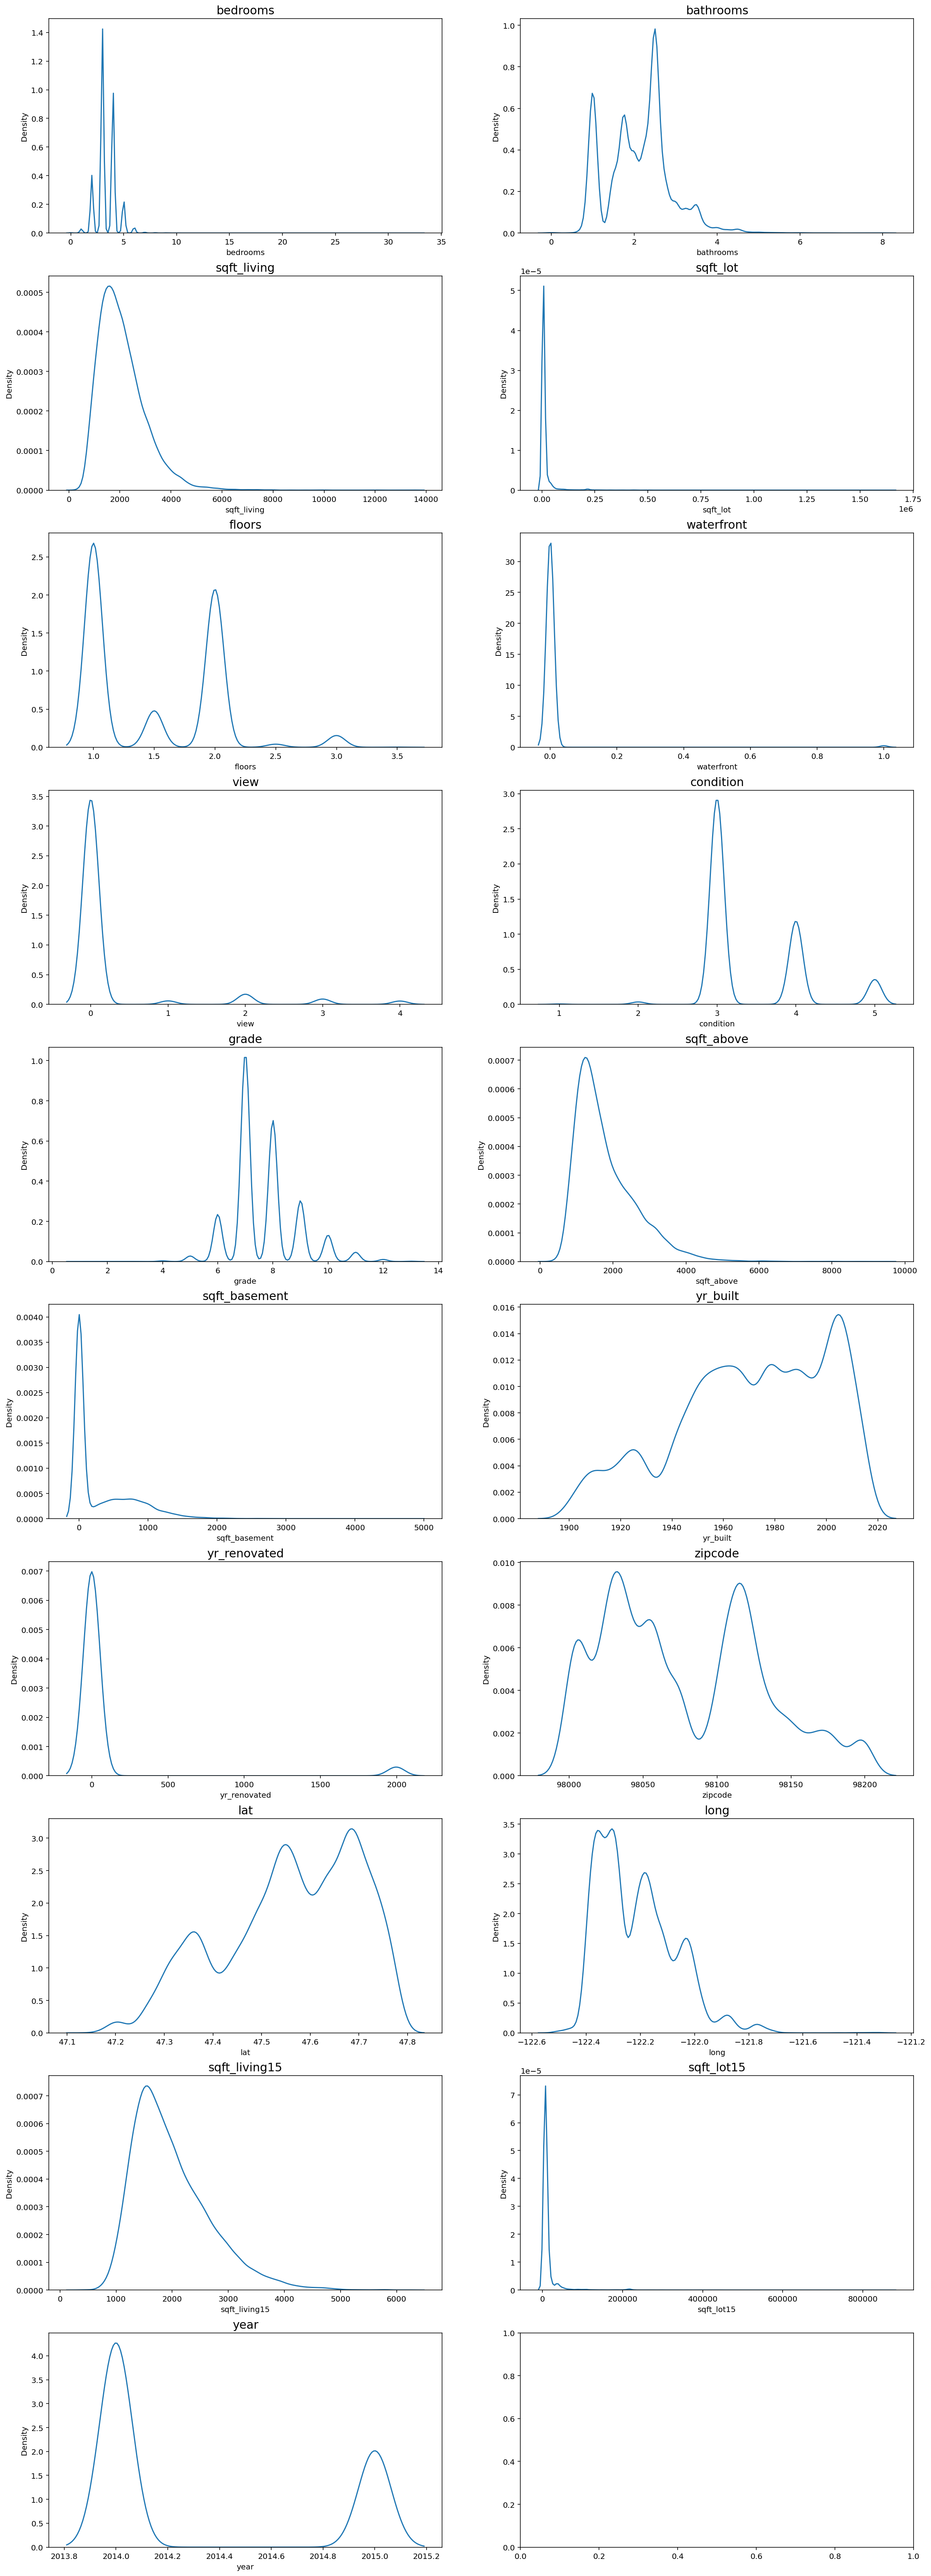

In [373]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [374]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

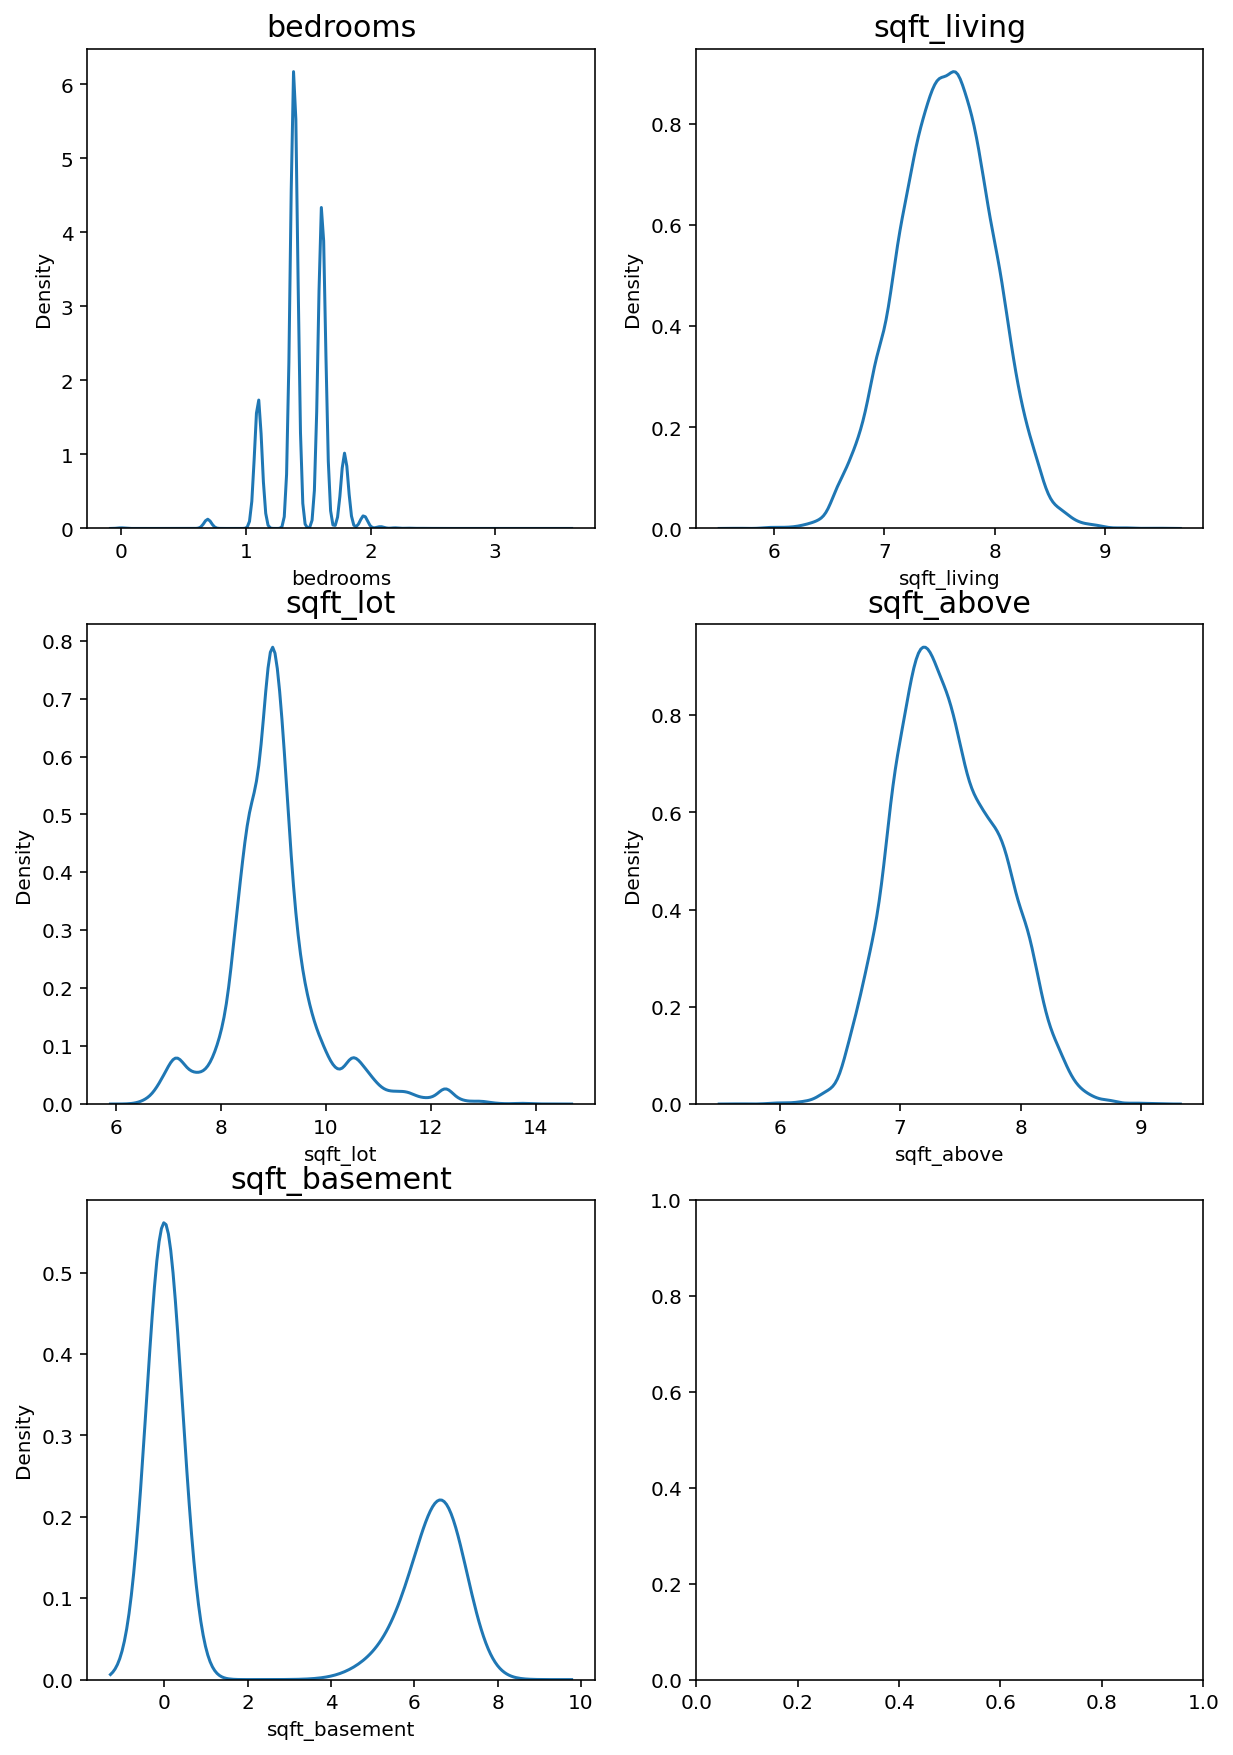

In [375]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [376]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21503 non-null  float64
 1   bathrooms      21503 non-null  float64
 2   sqft_living    21503 non-null  float64
 3   sqft_lot       21503 non-null  float64
 4   floors         21503 non-null  float64
 5   waterfront     21503 non-null  int64  
 6   view           21503 non-null  int64  
 7   condition      21503 non-null  int64  
 8   grade          21503 non-null  int64  
 9   sqft_above     21503 non-null  float64
 10  sqft_basement  21503 non-null  float64
 11  yr_built       21503 non-null  int64  
 12  yr_renovated   21503 non-null  int64  
 13  zipcode        21503 non-null  int64  
 14  lat            21503 non-null  float64
 15  long           21503 non-null  float64
 16  sqft_living15  21503 non-null  int64  
 17  sqft_lot15     21503 non-null  int64  
 18  year  

In [377]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

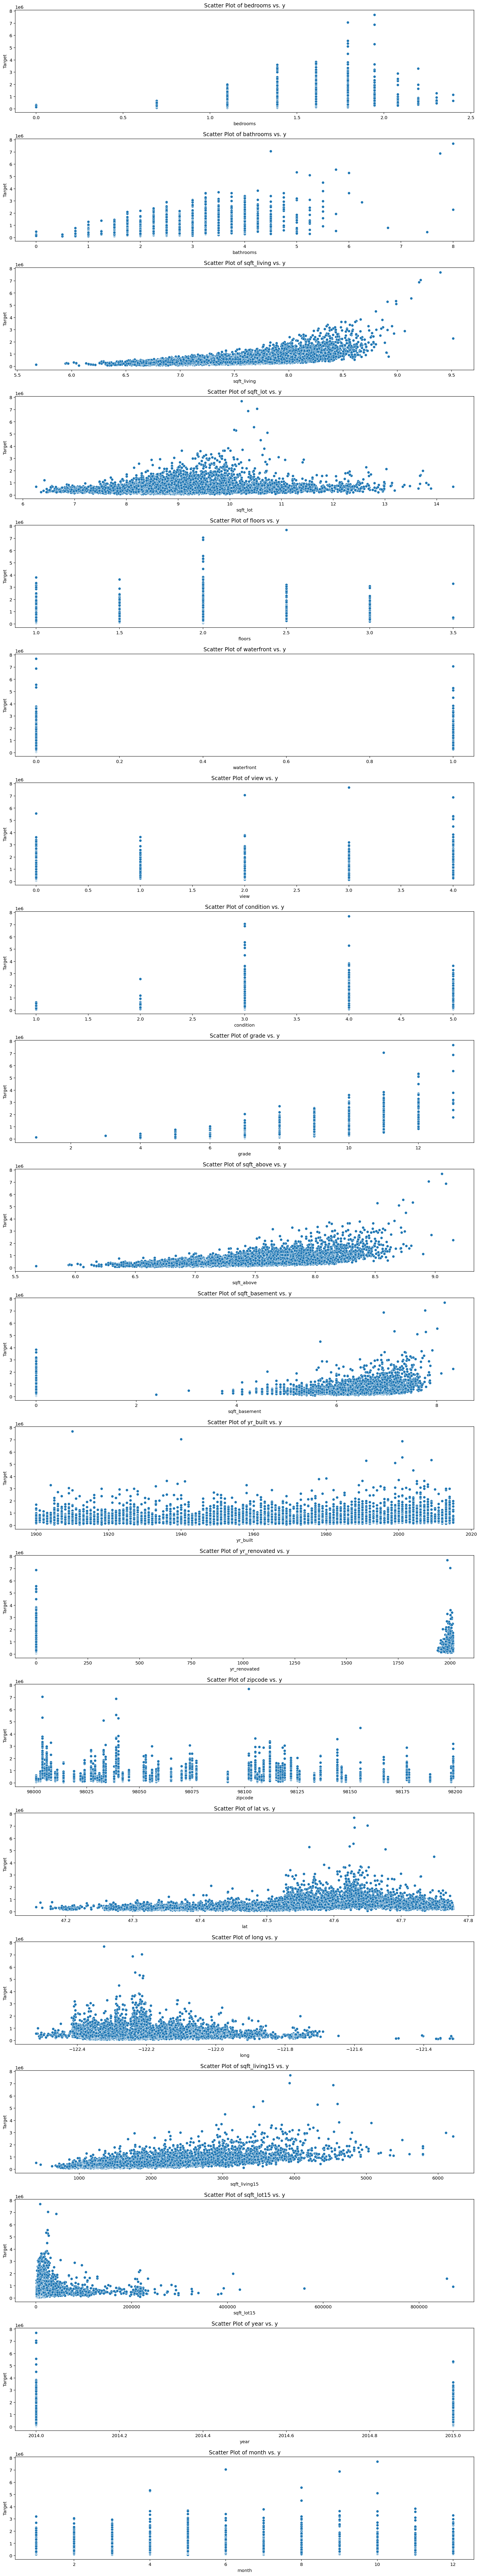

In [378]:
plt.figure(figsize=(15, 80))

for i, col in enumerate(x.columns, 1):
    plt.subplot(len(x.columns), 1, i)
    sns.scatterplot(x=x[col], y=y)
    plt.title(f'Scatter Plot of {col} vs. y')
    plt.xlabel(col)
    plt.ylabel('Target')

plt.tight_layout()
plt.show()

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [379]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':rdforest, 'name':'rdforest'}]

In [380]:
# RMSE 스코어 설정
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE를 계산하도록 설정

# 교차 검증 스코어 계산 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for m in models:
        # RMSE 기준으로 cross_val_score 계산
        cv_score = cross_val_score(m['model'], x.values, y, cv=kfold, scoring=rmse_scorer)
        print("Model {} CV RMSE : {:.4f}".format(m['name'], np.mean(cv_score)))

# 함수 호출
get_cv_score(models)

Model GradientBoosting CV RMSE : 138090.3496
Model XGBoost CV RMSE : 127791.5528
Model LightGBM CV RMSE : 131134.4977
Model rdforest CV RMSE : 135368.6222


### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [381]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

rmse_scorer = make_scorer(mean_squared_error, squared=False)  # squared=False로 설정해 RMSE를 계산

def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for m in models:
        # RMSE 기준으로 cross_val_score 계산
        cv_score = cross_val_score(m['model'], x.values, y, cv=kfold, scoring=rmse_scorer)
        print("Model {} CV RMSE : {:.4f}".format(m['name'], np.mean(cv_score)))

In [382]:
from sklearn.model_selection import KFold, cross_val_score

def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)  # shuffle=True 추가
    for m in models:
        cv_score = cross_val_score(m['model'], x.values, y, cv=kfold)
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cv_score)))

In [383]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8603
Model XGBoost CV score : 0.8794
Model LightGBM CV score : 0.8743
Model rdforest CV score : 0.8658


#### 시도 1

In [384]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21503 non-null  float64
 1   bathrooms      21503 non-null  float64
 2   sqft_living    21503 non-null  float64
 3   sqft_lot       21503 non-null  float64
 4   floors         21503 non-null  float64
 5   waterfront     21503 non-null  int64  
 6   view           21503 non-null  int64  
 7   condition      21503 non-null  int64  
 8   grade          21503 non-null  int64  
 9   sqft_above     21503 non-null  float64
 10  sqft_basement  21503 non-null  float64
 11  yr_built       21503 non-null  int64  
 12  yr_renovated   21503 non-null  int64  
 13  zipcode        21503 non-null  int64  
 14  lat            21503 non-null  float64
 15  long           21503 non-null  float64
 16  sqft_living15  21503 non-null  int64  
 17  sqft_lot15     21503 non-null  int64  
 18  year  

In [385]:
df1 = data

In [386]:
lat_bins = np.linspace(df1['lat'].min(), df1['lat'].max(), num=50)
long_bins = np.linspace(df1['long'].min(), df1['long'].max(), num=50)

In [387]:
df1['lat_bin'] = np.digitize(df1['lat'], bins=lat_bins)
df1['long_bin'] = np.digitize(df1['long'], bins=long_bins)

In [388]:
# 각 (lat_bin, long_bin) 조합에 대해 밀도(카운트) 계산
density_counts = df1.groupby(['lat_bin', 'long_bin']).size().reset_index(name='density')

# 원래 데이터와 밀도 값 매칭
df1 = df1.merge(density_counts, on=['lat_bin', 'long_bin'], how='left')

# 필요 없는 열 삭제
df1.drop(['lat_bin', 'long_bin'], axis=1, inplace=True)

# 결과 확인
df1[['lat', 'long', 'density']].head()

lat     long  density
0  47.5112 -122.257       48
1  47.7379 -122.233       92
2  47.6168 -122.045       59
3  47.3097 -122.327       42
4  47.4095 -122.315       32

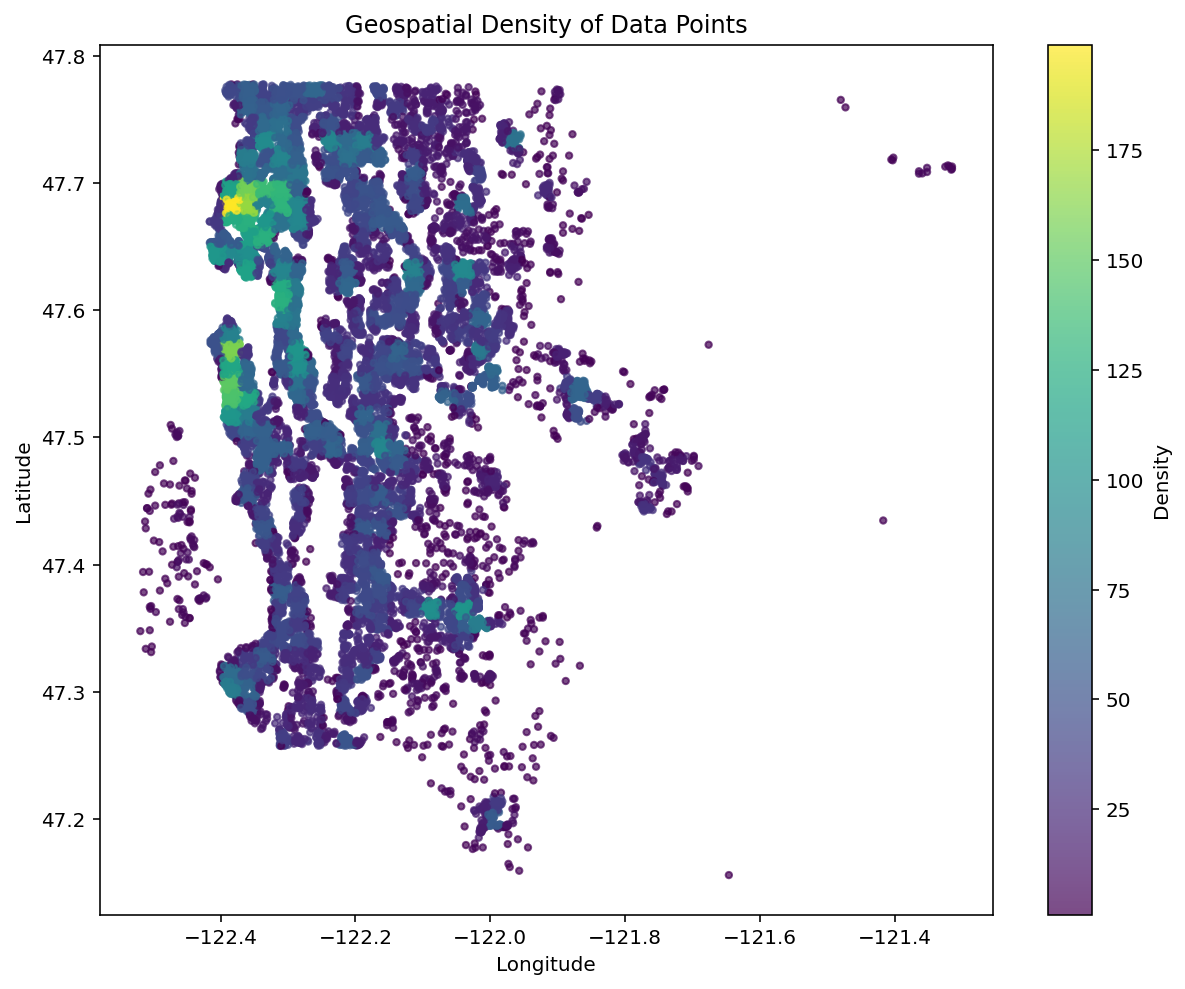

In [389]:
plt.figure(figsize=(10, 8))
density_plot = plt.scatter(df1['long'], df1['lat'], c=df1['density'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

In [390]:
df1.describe()

bedrooms     bathrooms   sqft_living      sqft_lot        floors  \
count  21503.000000  21503.000000  21503.000000  21503.000000  21503.000000   
mean       1.452955      2.116042      7.551722      8.990284      1.495140   
std        0.213407      0.770018      0.424418      0.902629      0.540183   
min        0.000000      0.000000      5.673323      6.255750      1.000000   
25%        1.386294      1.750000      7.266129      8.525360      1.000000   
50%        1.386294      2.250000      7.557473      8.938138      1.500000   
75%        1.609438      2.500000      7.844241      9.276783      2.000000   
max        3.526361      8.000000      9.513477     14.317110      3.500000   

         waterfront          view     condition         grade    sqft_above  \
count  21503.000000  21503.000000  21503.000000  21503.000000  21503.000000   
mean       0.007580      0.234618      3.409710      7.659164      7.396348   
std        0.086737      0.766453      0.650066      1.174422      0.427322   
min        0.000000      0.000000      1.000000      1.000000      5.673323   
25%        0.000000      0.000000      3.000000      7.000000      7.090910   
50%        0.000000      0.000000      3.000000      7.000000      7.353082   
75%        0.000000      0.000000      4.000000      8.000000      7.701200   
max        1.000000      4.000000      5.000000     13.000000      9.149634   

       ...      yr_built  yr_renovated       zipcode           lat  \
count  ...  21503.000000  21503.000000  21503.000000  21503.000000   
mean   ...   1971.055016     84.741943  98077.897968     47.560121   
std    ...     29.372398    402.452836     53.489890      0.138615   
min    ...   1900.000000      0.000000  98001.000000     47.155900   
25%    ...   1951.000000      0.000000  98033.000000     47.471100   
50%    ...   1975.000000      0.000000  98065.000000     47.571900   
75%    ...   1997.000000      0.000000  98117.000000     47.678100   
max    ...   2015.000000   2015.000000  98199.000000     47.777600   

               long  sqft_living15     sqft_lot15          year         month  \
count  21503.000000   21503.000000   21503.000000  21503.000000  21503.000000   
mean    -122.213786    1987.242664   12774.529089   2014.320560      6.583546   
std        0.140833     685.579479   27334.995914      0.466703      3.111287   
min     -122.519000     399.000000     651.000000   2014.000000      1.000000   
25%     -122.328000    1490.000000    5100.000000   2014.000000      4.000000   
50%     -122.230000    1840.000000    7620.000000   2014.000000      6.000000   
75%     -122.125000    2370.000000   10085.000000   2015.000000      9.000000   
max     -121.315000    6210.000000  871200.000000   2015.000000     12.000000   

            density  
count  21503.000000  
mean      58.546575  
std       39.380382  
min        1.000000  
25%       30.000000  
50%       50.000000  
75%       76.000000  
max      199.000000  

[8 rows x 21 columns]

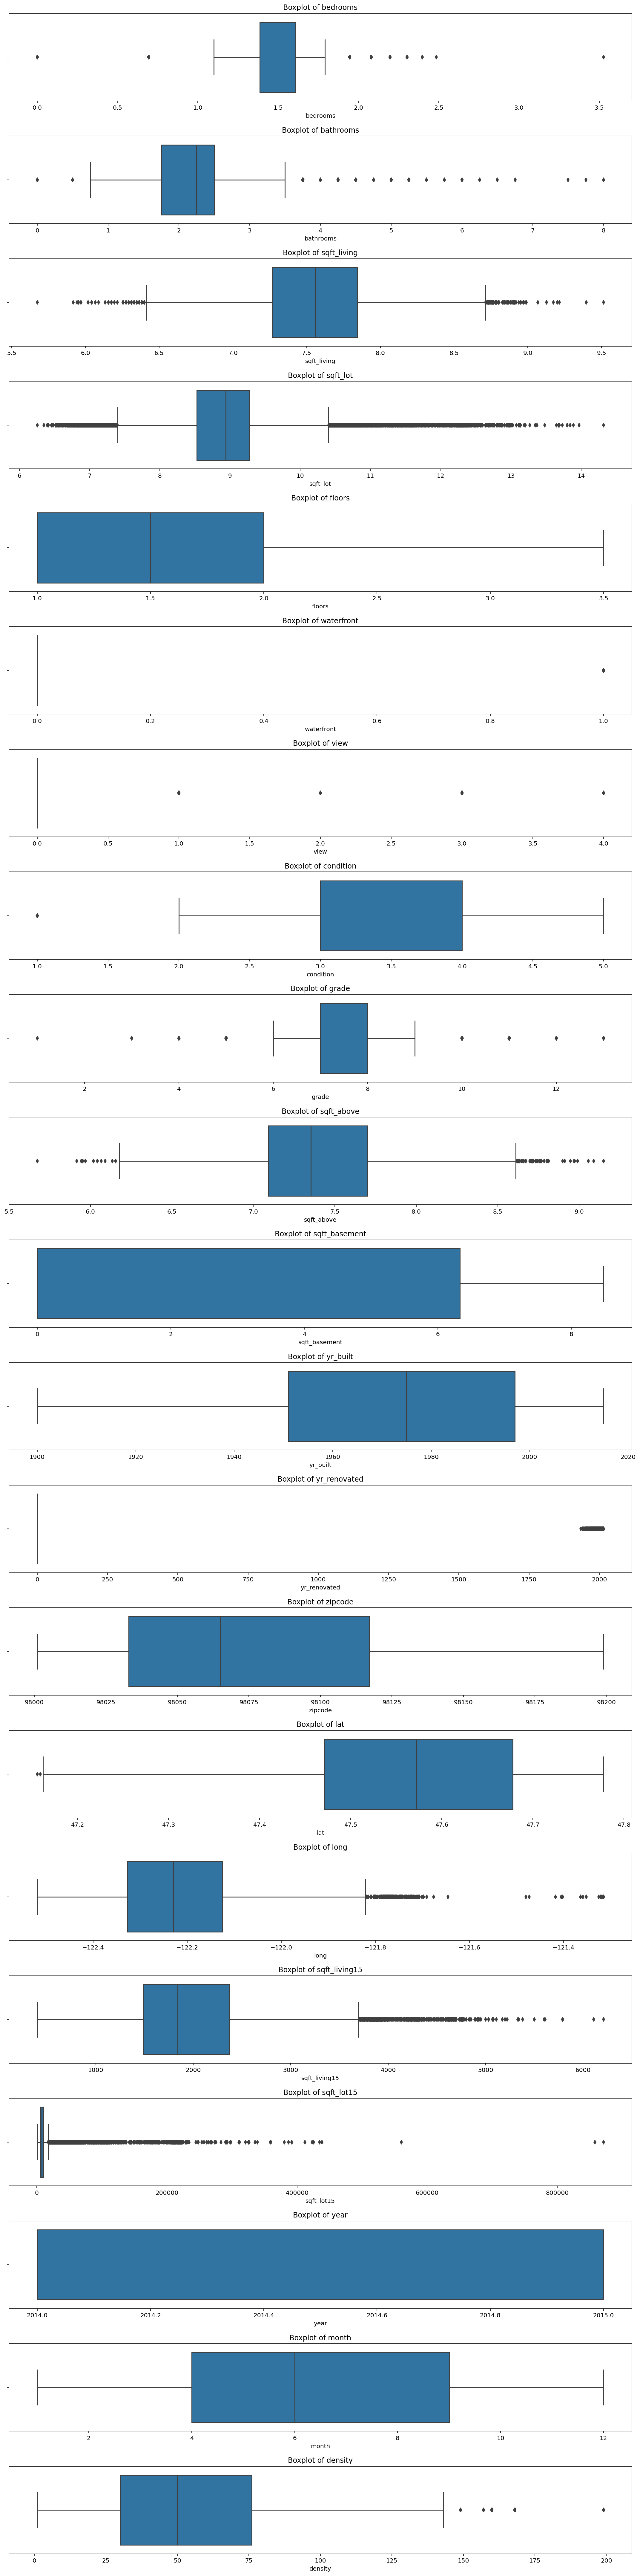

In [391]:
plt.figure(figsize=(15, 60))  # 전체 플롯 크기 설정
for i, col in enumerate(df1.columns, 1):
    plt.subplot(len(df1.columns), 1, i)
    sns.boxplot(data=df1, x=col)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [392]:
df1['real_living'] = df1['sqft_living']/df1['sqft_lot']

<AxesSubplot:xlabel='real_living', ylabel='price'>

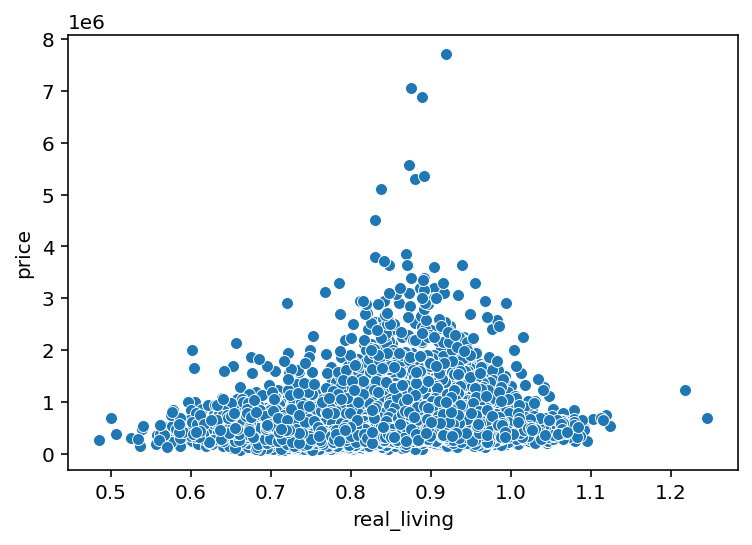

In [393]:
sns.scatterplot(df1['real_living'],y)

In [394]:
df1['yr_built'].value_counts()

2014    558
2006    454
2005    450
2004    431
2003    422
       ... 
1933     29
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [395]:
df1.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'density',
       'real_living'],
      dtype='object')

In [396]:
# 지하실 제외 실제 거주 평수 / 부지 평수

df1['real_living']=df1['sqft_above']/df1['sqft_lot']

<AxesSubplot:xlabel='real_living', ylabel='price'>

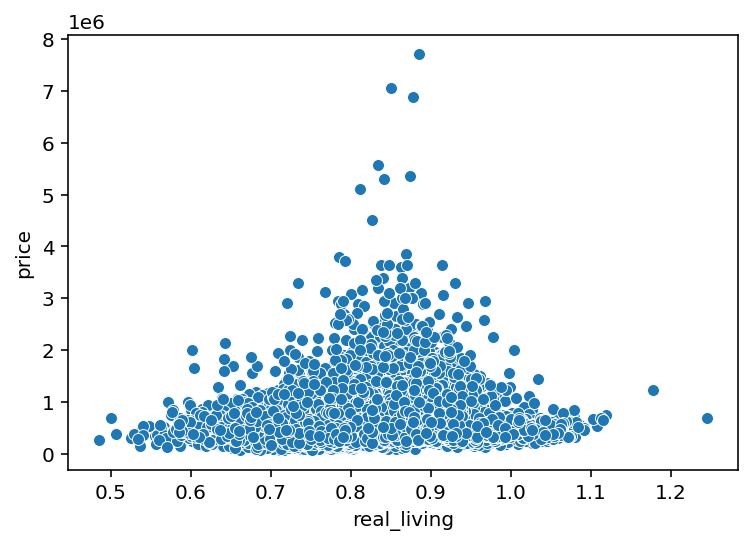

In [397]:
sns.scatterplot(df1['real_living'],y)

<AxesSubplot:xlabel='density', ylabel='price'>

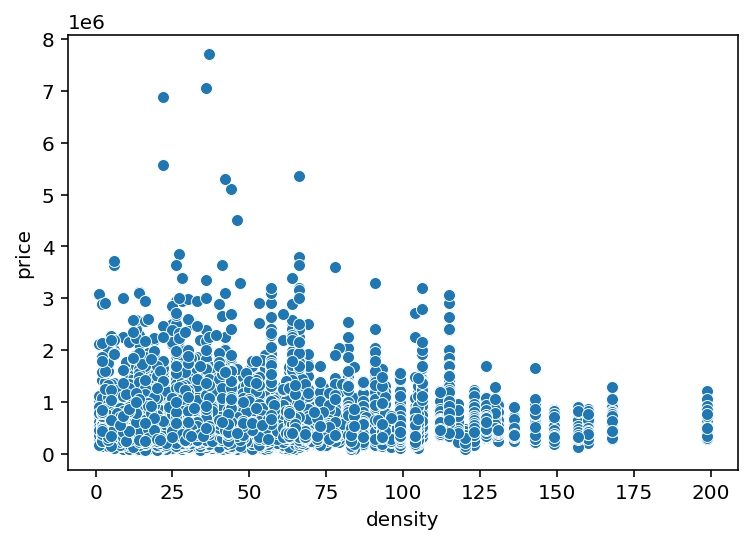

In [398]:
sns.scatterplot(df1['density'],y)

In [399]:
df1['sqft_basement'].value_counts()

0.000000    13056
6.398595      220
6.552508      217
6.216606      212
6.685861      206
            ...  
7.855932        1
7.694848        1
6.030685        1
8.089789        1
5.517453        1
Name: sqft_basement, Length: 306, dtype: int64

In [400]:
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [401]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 21502
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21503 non-null  float64
 1   bathrooms      21503 non-null  float64
 2   sqft_living    21503 non-null  float64
 3   sqft_lot       21503 non-null  float64
 4   floors         21503 non-null  float64
 5   waterfront     21503 non-null  int64  
 6   view           21503 non-null  int64  
 7   condition      21503 non-null  int64  
 8   grade          21503 non-null  int64  
 9   sqft_above     21503 non-null  float64
 10  sqft_basement  21503 non-null  float64
 11  yr_built       21503 non-null  int64  
 12  yr_renovated   21503 non-null  int64  
 13  zipcode        21503 non-null  int64  
 14  lat            21503 non-null  float64
 15  long           21503 non-null  float64
 16  sqft_living15  21503 non-null  int64  
 17  sqft_lot15     21503 non-null  int64  
 18  year  

In [403]:
df1

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0      1.386294       1.00     7.074117  8.639588     1.0           0     0   
1      1.098612       1.00     6.647688  9.210440     1.0           0     0   
2      1.386294       2.00     7.427144  8.997271     1.0           0     0   
3      1.386294       2.25     7.447751  8.827615     2.0           0     0   
4      1.386294       1.50     6.966967  9.181118     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21498  1.386294       1.75     7.313887  9.390075     1.0           0     0   
21499  1.386294       2.00     7.307202  7.027315     3.0           0     0   
21500  1.386294       2.50     7.178545  7.166266     2.0           0     0   
21501  1.098612       0.75     6.928538  7.208600     2.0           0     0   
21502  1.386294       2.50     7.378384  7.778630     2.0           0     0   

       condition  grade  sqft_above  ...  yr_renovated  zipcode      lat  \
0              3      7    7.074117  ...             0    98178  47.5112   
1              3      6    6.647688  ...             0    98028  47.7379   
2              3      8    7.427144  ...             0    98074  47.6168   
3              3      7    7.447751  ...             0    98003  47.3097   
4              3      7    6.966967  ...             0    98198  47.4095   
...          ...    ...         ...  ...           ...      ...      ...   
21498          3      6    7.313887  ...             0    98010  47.3095   
21499          3      8    7.307202  ...             0    98144  47.5699   
21500          3      8    7.074117  ...             0    98116  47.5773   
21501          3      7    6.928538  ...             0    98144  47.5944   
21502          3      8    7.378384  ...             0    98027  47.5345   

          long  sqft_living15  sqft_lot15  year  month  density  real_living  
0     -122.257           1340        5650  2014     10       48     0.818803  
1     -122.233           2720        8062  2015      2       92     0.721756  
2     -122.045           1800        7503  2015      2       59     0.825489  
3     -122.327           2238        6819  2014      6       42     0.843688  
4     -122.315           1650        9711  2015      1       32     0.758837  
...        ...            ...         ...   ...    ...      ...          ...  
21498 -122.002           1320       11303  2014      6       12     0.778895  
21499 -122.288           1400        1230  2015      1      104     1.039829  
21500 -122.409           1330        1265  2015      2       51     0.987141  
21501 -122.299           1020        2007  2014      6       87     0.961149  
21502 -122.069           1410        1287  2015      1       63     0.948545  

[21503 rows x 22 columns]

In [404]:
df1['sqft_lot15'] = np.where(df1['sqft_lot15'] >= 500000, np.nan,df1['sqft_lot15'])

In [405]:
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)

In [406]:
df1.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'density',
       'real_living'],
      dtype='object')

In [407]:
df1['zipcode'].value_counts()

98103    600
98038    587
98115    578
98052    571
98117    550
        ... 
98102    105
98010     99
98024     80
98148     56
98039     49
Name: zipcode, Length: 70, dtype: int64

In [408]:
df1['density'].value_counts()

40    440
36    432
46    414
65    390
48    384
     ... 
74     74
72     72
71     71
70     70
39     39
Name: density, Length: 108, dtype: int64

In [409]:
df1 = df1.drop(columns=['zipcode','yr_renovated','lat','long'])

In [410]:
df1.shape

(21500, 18)

In [411]:
sub = df1.iloc[train_len:, :]
x = df1.iloc[:train_len, :]

In [412]:
###########################
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  float64
 1   bathrooms      15035 non-null  float64
 2   sqft_living    15035 non-null  float64
 3   sqft_lot       15035 non-null  float64
 4   floors         15035 non-null  float64
 5   waterfront     15035 non-null  int64  
 6   view           15035 non-null  int64  
 7   condition      15035 non-null  int64  
 8   grade          15035 non-null  int64  
 9   sqft_above     15035 non-null  float64
 10  sqft_basement  15035 non-null  float64
 11  yr_built       15035 non-null  int64  
 12  sqft_living15  15035 non-null  int64  
 13  sqft_lot15     15035 non-null  float64
 14  year           15035 non-null  int64  
 15  month          15035 non-null  int64  
 16  density        15035 non-null  int64  
 17  real_living    15035 non-null  float64
dtypes: flo

In [413]:
# RMSE 스코어 설정
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # RMSE를 계산하도록 설정

# 교차 검증 스코어 계산 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for m in models:
        # RMSE 기준으로 cross_val_score 계산
        cv_score = cross_val_score(m['model'], x.values, y, cv=kfold, scoring=rmse_scorer)
        print("Model {} CV RMSE : {:.4f}".format(m['name'], np.mean(cv_score)))

# 함수 호출
get_cv_score(models)

Model GradientBoosting CV RMSE : 338724.7439
Model XGBoost CV RMSE : 353985.2897
Model LightGBM CV RMSE : 345612.8678
Model rdforest CV RMSE : 347015.6987


In [414]:
df1.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15', 'year',
       'month', 'density', 'real_living'],
      dtype='object')

### 하이퍼파라미터 따라가기

In [415]:
train_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'train.csv')
test_data_path = join('~/aiffel/kaggle_kakr_housing/data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [416]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

In [417]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

In [418]:
y = train['price']
del train['price']

print(train.columns)
del train['id']

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [419]:
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


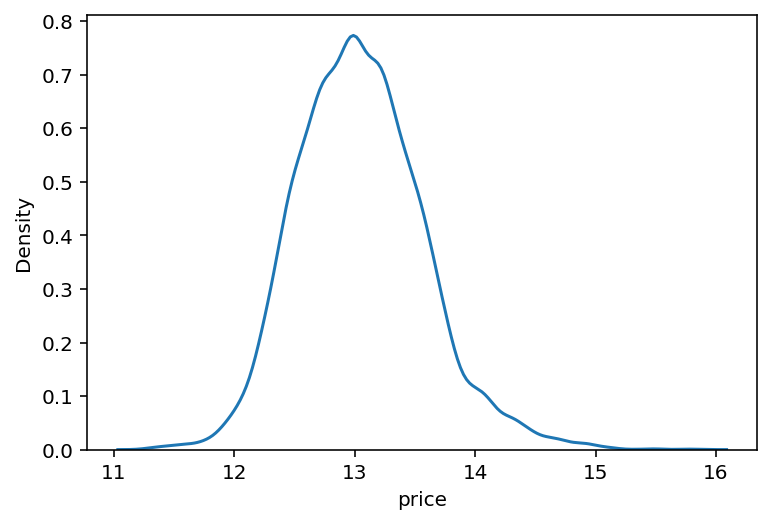

In [420]:
y = np.log1p(y)
y
sns.kdeplot(y)
plt.show()

In [421]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [422]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [423]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [424]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [425]:
def get_scores(models, train, y):
    results = {}  # 결과를 저장할 딕셔너리
    
    # 각 모델에 대해 학습 및 RMSE 계산
    for model in models:
        # 모델 이름
        model_name = model.__class__.__name__
        
        # Train/Test 데이터셋 분리 (8:2 비율)
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2020)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # 결과 저장
        results[model_name] = rmse

    # DataFrame으로 변환 및 정렬
    score_df = pd.DataFrame(results, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

# 함수 호출 예시
get_scores(models, x, y)

RMSE
XGBRegressor               0.502350
RandomForestRegressor      0.496702
LGBMRegressor              0.487953
GradientBoostingRegressor  0.486959

In [426]:
from sklearn.model_selection import GridSearchCV

In [427]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [428]:
model = LGBMRegressor(random_state=random_state)

In [429]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [430]:
grid_model.cv_results_

{'mean_fit_time': array([0.44902315, 0.65609589, 1.15880637, 1.63599482]),
 'std_fit_time': array([0.09198742, 0.14518556, 0.15812538, 0.22945071]),
 'mean_score_time': array([0.0204813 , 0.04200206, 0.08064146, 0.08826146]),
 'std_score_time': array([0.00531827, 0.01813797, 0.02404082, 0.05283523]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [431]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [432]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [433]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])

# RMSE를 RMSLE로 열 이름 변경
results = results.rename(columns={'RMSE': 'RMSLE'})

# 결과 확인
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

In [434]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [435]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

In [436]:
# 결과 확인
results
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [437]:
sub = pd.DataFrame(data={'id': sub_id, 'price': prediction})

In [438]:
sub.to_csv('submission2.csv', index=False)

## 시도 3

In [439]:
df1

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0      1.386294       1.00     7.074117  8.639588     1.0           0     0   
1      1.098612       1.00     6.647688  9.210440     1.0           0     0   
2      1.386294       2.00     7.427144  8.997271     1.0           0     0   
3      1.386294       2.25     7.447751  8.827615     2.0           0     0   
4      1.386294       1.50     6.966967  9.181118     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21495  1.386294       1.75     7.313887  9.390075     1.0           0     0   
21496  1.386294       2.00     7.307202  7.027315     3.0           0     0   
21497  1.386294       2.50     7.178545  7.166266     2.0           0     0   
21498  1.098612       0.75     6.928538  7.208600     2.0           0     0   
21499  1.386294       2.50     7.378384  7.778630     2.0           0     0   

       condition  grade  sqft_above  sqft_basement  yr_built  sqft_living15  \
0              3      7    7.074117       0.000000      1955           1340   
1              3      6    6.647688       0.000000      1933           2720   
2              3      8    7.427144       0.000000      1987           1800   
3              3      7    7.447751       0.000000      1995           2238   
4              3      7    6.966967       0.000000      1963           1650   
...          ...    ...         ...            ...       ...            ...   
21495          3      6    7.313887       0.000000      2014           1320   
21496          3      8    7.307202       0.000000      2014           1400   
21497          3      8    7.074117       4.875197      2008           1330   
21498          3      7    6.928538       0.000000      2009           1020   
21499          3      8    7.378384       0.000000      2004           1410   

       sqft_lot15  year  month  density  real_living  
0          5650.0  2014     10       48     0.818803  
1          8062.0  2015      2       92     0.721756  
2          7503.0  2015      2       59     0.825489  
3          6819.0  2014      6       42     0.843688  
4          9711.0  2015      1       32     0.758837  
...           ...   ...    ...      ...          ...  
21495     11303.0  2014      6       12     0.778895  
21496      1230.0  2015      1      104     1.039829  
21497      1265.0  2015      2       51     0.987141  
21498      2007.0  2014      6       87     0.961149  
21499      1287.0  2015      1       63     0.948545  

[21500 rows x 18 columns]

In [440]:
sub = df1.iloc[train_len:, :]
x = df1.iloc[:train_len, :]

In [441]:
x.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15', 'year',
       'month', 'density', 'real_living'],
      dtype='object')

In [442]:
sub.shape

(6465, 18)

In [443]:
x.shape

(15035, 18)

In [444]:
y = np.log1p(y)
y

0        2.588515
1        2.572667
2        2.649161
3        2.599632
4        2.608893
           ...   
15030    2.661820
15031    2.696179
15032    2.624224
15033    2.631833
15034    2.616781
Name: price, Length: 15035, dtype: float64

In [445]:
y.shape

(15035,)

In [446]:
models = [
    {'model': GradientBoostingRegressor(random_state=2020), 'name': 'GradientBoosting'},
    {'model': XGBRegressor(random_state=2020), 'name': 'XGBoost'},
    {'model': LGBMRegressor(random_state=2020), 'name': 'LightGBM'},
    {'model': RandomForestRegressor(random_state=2020), 'name': 'RandomForest'}
]

In [447]:
def get_scores(models, x, y):
    results = {}  # 결과를 저장할 딕셔너리
    
    for m in models:
        # 모델과 모델 이름
        model = m['model']
        model_name = m['name']
        
        # Train/Test 데이터셋 분리 (8:2 비율)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2020)
        
        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # 결과 저장
        results[model_name] = rmse

    # DataFrame으로 변환 및 정렬
    score_df = pd.DataFrame(results, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

# 함수 호출 및 결과 출력
score_df = get_scores(models, x, y)
print(score_df)

                      RMSE
XGBoost           0.035742
RandomForest      0.035021
LightGBM          0.034417
GradientBoosting  0.034313


In [448]:
get_scores(models, x, y)

RMSE
XGBoost           0.035742
RandomForest      0.035021
LightGBM          0.034417
GradientBoosting  0.034313

In [449]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [450]:
model = GradientBoostingRegressor(random_state=random_state)

In [451]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(x, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=2020),
             n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [452]:
grid_model.cv_results_
params = grid_model.cv_results_['params']
params
score = grid_model.cv_results_['mean_test_score']
score
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])

# RMSE를 RMSLE로 열 이름 변경
results = results.rename(columns={'RMSE': 'RMSLE'})

# 결과 확인
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.001301  0.036071
1          1           100 -0.001299  0.036046
2         10            50 -0.001379  0.037139
3         10           100 -0.001405  0.037482

In [454]:
model = GradientBoostingRegressor(max_depth=1, n_estimators=50, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([13.22948733, 12.81222984, 13.87594193, ..., 13.03453838,
       12.88614107, 13.01143841])

In [455]:
#################################
sub = pd.DataFrame(data={'id': sub_id, 'price': prediction})

In [456]:
sub.to_csv('submission4_GradientBoosting.csv', index=False)

###  시도4

In [ ]:
df2 = df1.copy()
sub = df2.iloc[train_len:, :]
x = df2.iloc[:train_len, :]
y = np.log1p(y)
y

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [ ]:
model = LGBMRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

In [ ]:
grid_model.cv_results_
params = grid_model.cv_results_['params']
params
score = grid_model.cv_results_['mean_test_score']
score
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])

# RMSE를 RMSLE로 열 이름 변경
results = results.rename(columns={'RMSE': 'RMSLE'})

# 결과 확인
results
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [142]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [143]:
y_pred = AveragingBlending(models, x, y, sub)

In [144]:
y_pred.shape

(6468,)

In [145]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [146]:
sub.to_csv('submission1.csv', index=False)

In [147]:
print(os.getcwd())

/aiffel/aiffel/kaggle_kakr_housing
